## 물건의 수요량 예측
댓글 5만개를 읽어서 다음주의 수요량을 예측 하는 모델을 만든다.
LSTM모델을 이용할 것입니다.

몇개가 팔릴 것인지를 예측해야 한다.

### 데이터 수집
https://smartstore.naver.com/myhome_chair/products/280423930?NaPm=ct%3Dknjnxk7k%7Cci%3D45a7efc3534276f543c56e1c965dffd4cd168ea5%7Ctr%3Dslsl%7Csn%3D258581%7Chk%3D8b09644e850ca7e816e358602724992d0fb2a0c4

#### 대상
네이버 쇼핑에 특정 키워드로 검색 했을 때 나오는 광고가 붙지 않은 상위 노출 상품 1, 2번

https://smartstore.naver.com/i/v1/reviews/paged-reviews?page=4&pageSize=20&merchantNo=500071344&originProductNo=280423930&sortType=REVIEW_CREATE_DATE_DESC
네이버 쇼핑 검색 결과에서 특정 물건의 모든 댓글 정보를 모두 수집 합니다.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt

# df = pd.read_json('r.json', dtype={'createDate':'date'})
df = pd.read_json('./328054674/r.json')
df.index = df['id']
df['createDate'] = pd.to_datetime(df['createDate'], format="%Y-%m-%d")
# df['createDate']=df['createDate'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18330 entries, 3155457135 to 155133707
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   id                              18330 non-null  int64              
 1   reviewServiceType               18330 non-null  object             
 2   reviewType                      18330 non-null  object             
 3   reviewContentClassType          18330 non-null  object             
 4   reviewContent                   18330 non-null  object             
 5   createDate                      18330 non-null  datetime64[ns, UTC]
 6   reviewDisplayStatusType         18330 non-null  object             
 7   repurchase                      3105 non-null   float64            
 8   parentReviewSeq                 913 non-null    float64            
 9   reviewScore                     18330 non-null  int64              
 1

In [2]:
df = df[['reviewServiceType', 'createDate', 'reviewContent', 'reviewScore', 'productOptionContent']].iloc[:, 0:30]
df['createDate'] = pd.to_datetime(df['createDate']).dt.strftime('%Y-%m-%d')
df

,reviewServiceType,createDate,reviewContent,reviewScore,productOptionContent
id,,,,,
3155457135,SELLBLOG,2021-04-16,아주 만족스럽게 잘쓰고있습니다,5,컬러: 브라운 / 구성: 등받이벤치형(벤치1+의자2)
3155438491,SELLBLOG,2021-04-16,좋아요 \n캣타워로 안성맞춤!,5,컬러: 브라운 / 구성: 등받이벤치형(벤치1+의자2)
3155418496,SELLBLOG,2021-04-16,가성비좋아요 ㅠㅠㅐ\n이렇게 파시면 남는게 있나요..?,5,컬러: 네츄럴 / 구성: 쿠션벤치형(벤치1+의자2)
3155290377,SELLBLOG,2021-04-16,배송은 일주일 정도 걸렸고 친절하게 다 설치해주고 가셨어요 식탁 색도 밝고 예쁘고 ...,5,컬러: 네츄럴 / 구성: 체어형(의자4개)
3155236430,SELLBLOG,2021-04-16,와~~ 너무 예뻐요 ~~ \n싸보이지 않고 갈끔한 마감까지 마음에 들어요,5,컬러: 브라운 / 구성: 체어형(의자4개)
...,...,...,...,...,...
155294531,SELLBLOG,2015-11-20,볼트 안가져와서 괜히 엄마성질내고 배송료는 먼저 받아가시고 저야 직접 못봤는데 혼만...,3,Nordic 노블 4인 식탁세트: Nordic 노블 4인 식탁세트(11월16일이후 ...
155282763,SELLBLOG,2015-11-20,저렴한가격에 싸보이지 않고 좋아요,5,Nordic 노블 4인 식탁세트: Nordic 노블 4인 식탁세트(11월16일이후 ...
155232810,SELLBLOG,2015-11-19,잘받았습니다 배송이좀 많이늦은것 빼고\n좋아요~^^,5,Nordic 노블 4인 식탁세트: Nordic 노블 4인 식탁세트(11월16일이후 ...


### 데이터 확인
reviewScore:1~5
productOptionContent:옵션

<AxesSubplot:xlabel='createDate'>

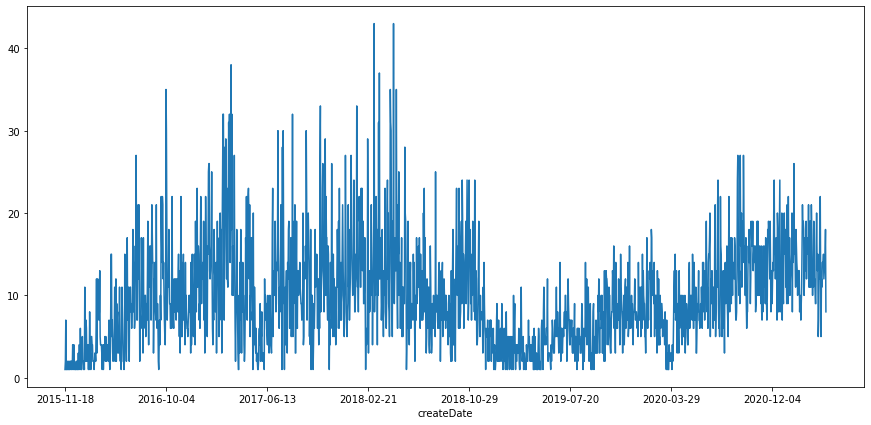

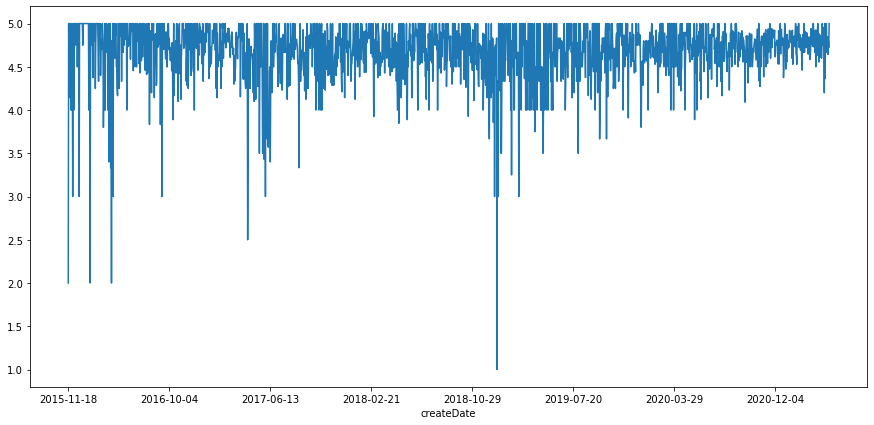

In [3]:
# 댓글 개수
fig, ax = plt.subplots(figsize=(15,7))
df.groupby('createDate').count()['reviewContent'].plot(ax=ax)

# 평점의 평균
fig, ax = plt.subplots(figsize=(15,7))
df.groupby('createDate').mean()['reviewScore'].plot(ax=ax)

리뷰의 수가 계속 증가하는 추세로 볼 수 있습니다.

### 데이터 전처리
주로 나누어서 그 7일 동안 상품별로 몇개의 리뷰가 달렸는지부터

### 정규화


지난 7일간의 평점 평균이 높아지면 댓글 수가 늘어나는지?

